# Multimodel Retrieval using BGE-VL

In this notebook, we show a very simple case of using BGE-VL model on text to image and (image, text) to image retrieval tasks.

## Preparation

Make sure you have the following dependencies installed in your environment:

In [ ]:
%pip install numpy torch transformers faiss-cpu pillow

## Dataset

[CIRCO](https://github.com/miccunifi/CIRCO) is a well labeled multimodel dataset, which use images taken from the [COCO 2017 unlabeled set](https://cocodataset.org/#home).

If you are interested in trying the full dataset:

In [ ]:
# !wget http://images.cocodataset.org/zips/unlabeled2017.zip
# !unzip unlabeled2017.zip

Due to the tremendous size of the original dataset, we prepare a subset of it as a small corpus in our repo. Clone the repo and you can find them in MegaPairs/assets/corpus/

In [1]:
import os

fid_to_oid = {}
image_dir = "./assets/corpus/"
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]

# extract image id from the path, and store the {sequence id: image id}
# sequence id will be used as FAISS's default id
for i, img in enumerate(image_paths):
    fid_to_oid[i] = int(img[-16:-4])

In [2]:
# function that convert image id back to path for later use
def id_to_name(id, image_dir):
    return image_dir + str(id).zfill(12) + ".jpg"

## Embedding and Indexing

First, use BGE-VL to encode the whole corpus:

In [ ]:
import numpy as np
import torch
from transformers import AutoModel

MODEL_NAME = "BAAI/BGE-VL-large" # or "BAAI/BGE-VL-base"

model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True) # You must set trust_remote_code=True
model.set_processor(MODEL_NAME)
model.eval()

with torch.no_grad():
    embeddings = model.encode(image_paths).to('cpu')

embeddings = np.array(embeddings).astype(np.float32)

In [5]:
print(embeddings.shape)

(11, 768)


Then store all the embeddings in an FAISS index.

In [6]:
import faiss

dim = embeddings.shape[1]
index = faiss.index_factory(dim, "Flat", faiss.METRIC_L2)

index.add(embeddings)

or you can directly load a saved index:

In [7]:
# index = faiss.read_index("./index.bin")

## Text -> Image

The first task is using a query text to retrieve relevant images. Let's have a try with the following queries:

In [8]:
queries = [
    "Find a picture of oranges in a blue basket",
    "Find a picture of both oranges and bananas",
]

In [9]:
k = 1

with torch.no_grad():
    queries_vec = model.encode(
        text = queries,
    ).to('cpu')

D, I = index.search(queries_vec, k=k)

We can see that the results follow the instruction well in details:

query text: Find a picture of oranges in a blue basket
['./assets/corpus/000000275230.jpg']


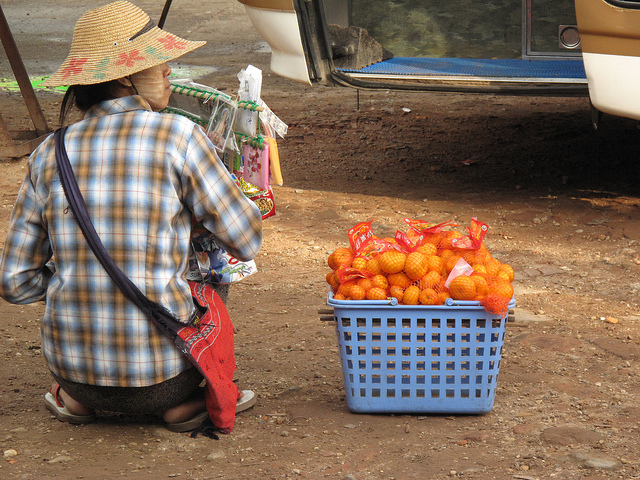

query text: Find a picture of both oranges and bananas
['./assets/corpus/000000156031.jpg']


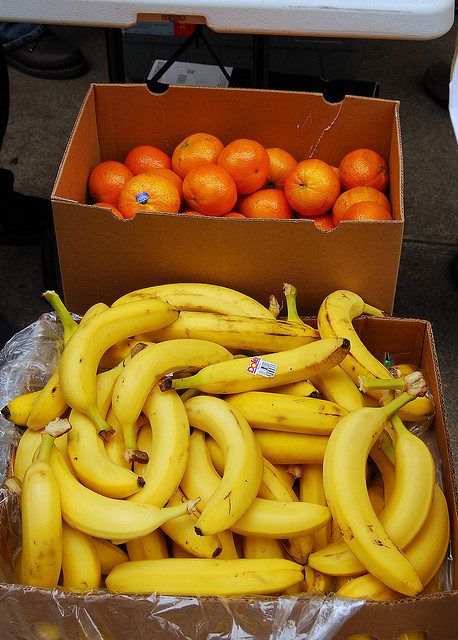

In [10]:
from IPython.display import Image, display

for i in range(len(queries)):
    print(f"query text: {queries[i]}")
    
    ids = [fid_to_oid[ind] for ind in I[i]]
    names = list(map(id_to_name, ids, [image_dir]*k))
    images = list(map(Image, names))
    print(names)
    display(*images)

## (Image, Text) -> Image

The second task is using the combination of image and text query to retrieve image:

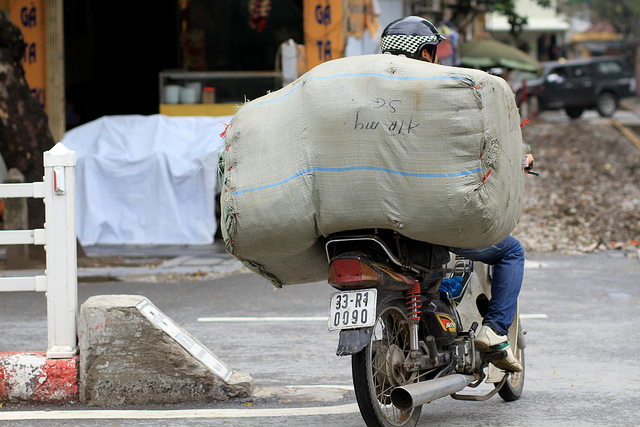

In [11]:
query_img_pth = "./assets/query/000000530944.jpg"
Image(filename=query_img_pth)

With the following text query, we want an image that a motorbike carrying a bag of orange:

In [12]:
k = 3

with torch.no_grad():
    query = model.encode(
        images = query_img_pth,
        text = "Find a picture that also a motorbike but replace the load to a bag of orange"
    ).to('cpu')

D, I = index.search(query, k=k)

We can see that the No.1 result perfectly match our requirements! And the other 2 in the top 3 results also show very relevant images.

['./assets/corpus/000000545037.jpg', './assets/corpus/000000272130.jpg', './assets/corpus/000000098911.jpg']


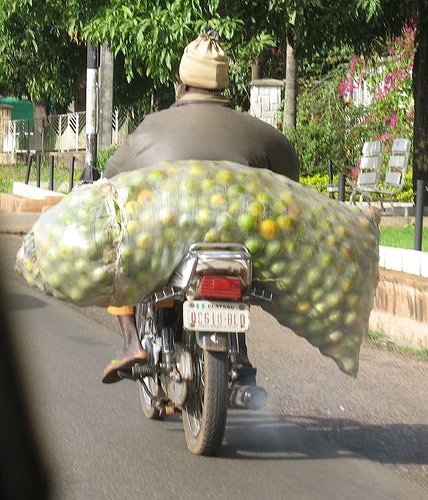

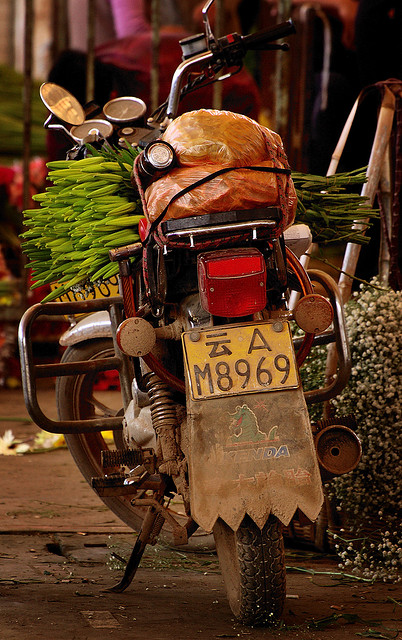

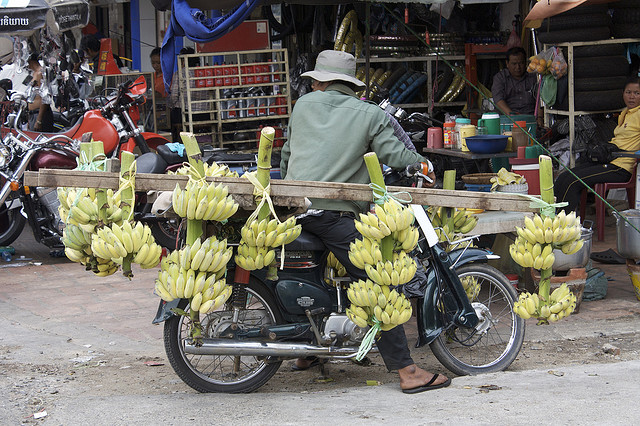

In [13]:
ids = [fid_to_oid[ind] for ind in I[0]]
names = list(map(id_to_name, ids, [image_dir]*k))
images = list(map(Image, names))
print(names)
display(*images)